El dilema sesgo vs varianza --- 31:06
===

* Ultima modificación: 2023-02-27 | [YouTube](https://www.youtube.com/watch?v=AmoPL4zPIbE&list=PLEFpZ3YehTnD1Cic9Xx92wWSvEUMYhUBD&index=1)

Uno de los problemas fundamentales en analítica predictiva es determinar la complejidad óptima del modelo. En este tutorial se discuten los conceptos de aprendizaje y generalización, y como obtener el mejor modelo a partir de los datos.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

## Proceso generador de los datos

El proceso generador de datos es un proceso invisible que produce datos observables en el mundo real. Cuando se construye un modelo de regresión este es el proceso que se desea representar. A continuación se presenta un ejemplo numérico para ilustrar los conceptos.

Existe un proceso generador de datos $f(x)$ que produce la salida $y$ ante la entrada $x$. Este proceso es desconocido. Para efectos de este ejemplo, este será representado mediante la siguiente función:

In [2]:
#
# Función a aproximar
# (Proceso geneador de datos)
#
def f(x):
    return 2 * np.abs(np.sin(x * np.pi / 4 + 0.75)) / (1 + 0.1 * x)


#
# Datos reales.
# (No disponibles en la realidad)
#
x_real = np.linspace(0, 10, 100)
X_real = x_real[:, np.newaxis]
y_real = f(x_real)

## Muestra de datos

Cuando se construye un modelo de regresión que aproxime el comportamiento de $f(\cdot)$, los parámetros son calibrados mediante una muestra de datos, representada por las parejas $(x_i, d_i)$. La salida $d_i$ no es exactamente $f(x_i)$ en la realidad, ya que el valor $y_i$ está contaminado con ruído. 

In [3]:
#
# Muestra de datos.
# (Información disponible en la realidad)
#
rng = np.random.default_rng(12345)

x_sample = x_real.copy()
rng.shuffle(x_sample)
x_sample = x_sample[:25]
x_sample = np.sort(x_sample)

y_sample = f(x_sample)
X_sample = x_sample[:, np.newaxis]

## Modelo de regresión

Por facilidad, se usará un polinomio de grado $N$ para realizar la regresión:

$$y_p = g(x_p) = \phi_0 + \sum_{n=1}^N \phi_n x_p^n$$

donde el subíndice $p$ representa cada uno de los puntos de la muestra de datos.

## Función de pérdida

En aprendizaje automático, el proceso de aprendizaje consiste en estimar los valores de los parámetros $\phi_n$, para $n=1, ...,N$ que minimizan un error o pérdida. Una selección común es el promedio de errores al cuadrado:

$$\text{MSE} = \frac{1}{P} \sum_{p=1}^P (d_p - y_p)^2 = \frac{1}{P} \sum_{p=1}^P [d_p - g(x_p)]^2$$ 

## Ajuste del modelo a los datos disponibles

El concepto de aprendizaje se refiere a que el modelo realmente capture el comportamiento del proceso generador de los datos (no visible). A continuación, se grafica el proceso subyacente y el comportamiento del polinomio para distintos grados. 

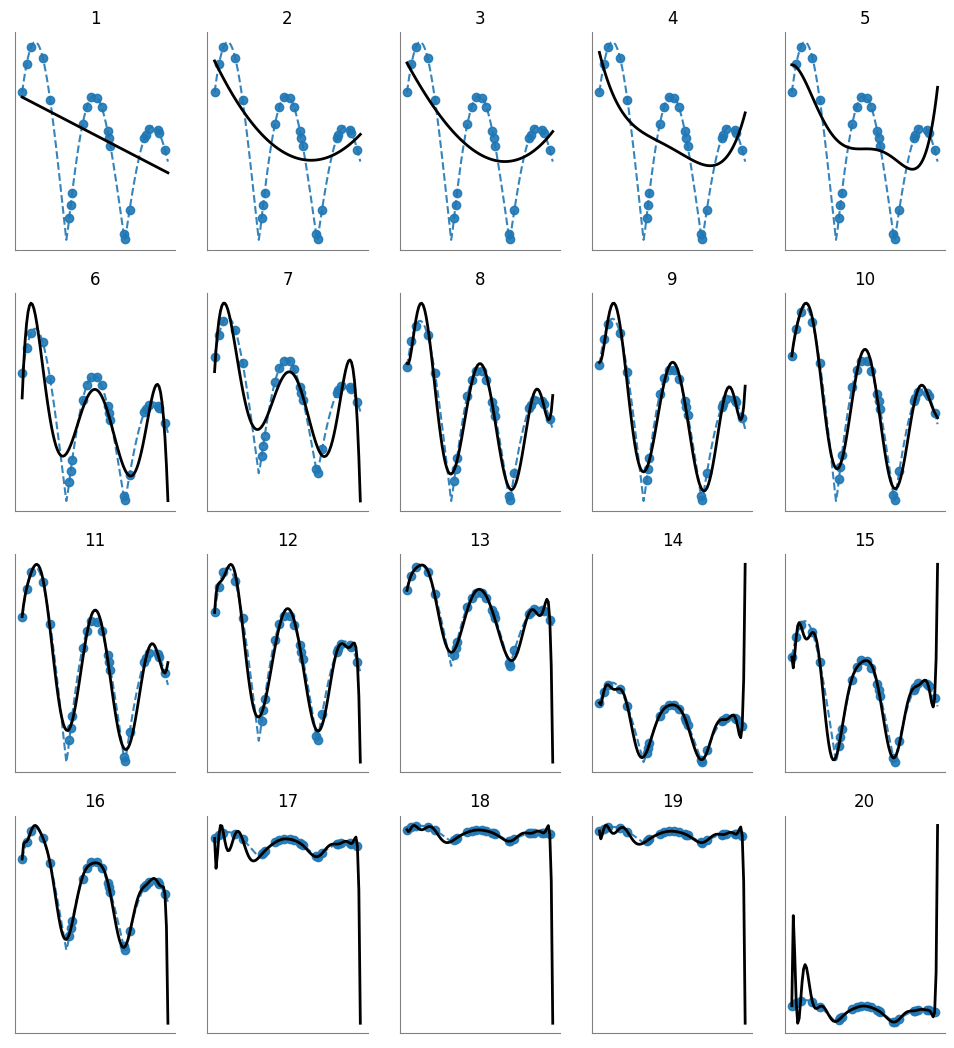

In [4]:
plt.figure(figsize=(12, 13))

degrees = list(range(1, 21))

for i_degree, degree in enumerate(degrees):

    plt.subplot(4, 5, i_degree + 1)

    #
    # Datos
    #
    plt.plot(x_real, y_real, "--", color="tab:blue", alpha=0.9)
    plt.plot(x_sample, y_sample, "o", color="tab:blue", alpha=0.9)

    #
    # Modelo
    #
    model = make_pipeline(
        PolynomialFeatures(degree, include_bias=False),
        MinMaxScaler(),
        LinearRegression(),
    )
    model.fit(X_sample, y_sample)
    y_predicted = model.predict(X_real)

    plt.plot(
        x_real,
        y_predicted,
        color="black",
        linewidth=2,
    )
    plt.title(str(degree))
    plt.xticks([], [])
    plt.yticks([], [])

    plt.gca().spines["left"].set_color("gray")
    plt.gca().spines["bottom"].set_color("gray")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)


plt.show()

En este caso, se puede suponer que el grado del polinomio es una medida de la complejidad del modelo; a mayor grado, mayor complejidad.

De acuedo con la gráfica anterior, se reconocen tres casos:


* **Subajuste**: El modelo no reproduce adecuadamente el comportamiento de los datos usados para estimar sus parámetros, ni del comportamiento subyacente.


* **Sobreajuste**: El modelo empieza a memorizar los datos de entrenamiento; es decir, muy bajo error de ajuste entre puntos, pero oscila locamente entre punto y punto para los puntos de la muestra de entrenamiento.


* **Ajuste óptimo**: El modelo tiene un bajo error de ajuste y el comportamiento de la linea roja es muy similar al comportamiento de la línea negra.

## Dilema sesgo - varianza

El término **sesgo** hace referencia a que tan bien se comporta el modelo para la muestra de datos disponible. En otras palabras, es el error pronedio para diferentes muestrad de entrenamiento. 

El término **varianza** hace referencia a que tan bien se comporta el modelo para datos nuevos no disponibles hasta ahora (el modelo entra en productivo). En otras palabras, indica que tan sensitivos son los resultados obtenidos al variar el conjunto de entrenamiento.

El dilema sesgo - varianza se refiere que a medida que el modelo aumenta su ajuste a los datos de entrenamiento (disminuye el sesgo), existe un punto a partir del cual aumenta la variabilidad de sus resultados para datos nuevos (aumenta la varianza).

El dilema se presenta al querer disminuir simultáneamente el sesgo y la varianza.

En el gráfico anterior, a medida que aumenta la complejidad (el grado) del modelo, hay un mejor ajuste a los datos conocidos (muestra de entrenamiento), pero el modelo produce una salida muy volatil para puntos por fuera de la muestra (que aumenta con la complejidad del modelo).

## Cómputo de los errores

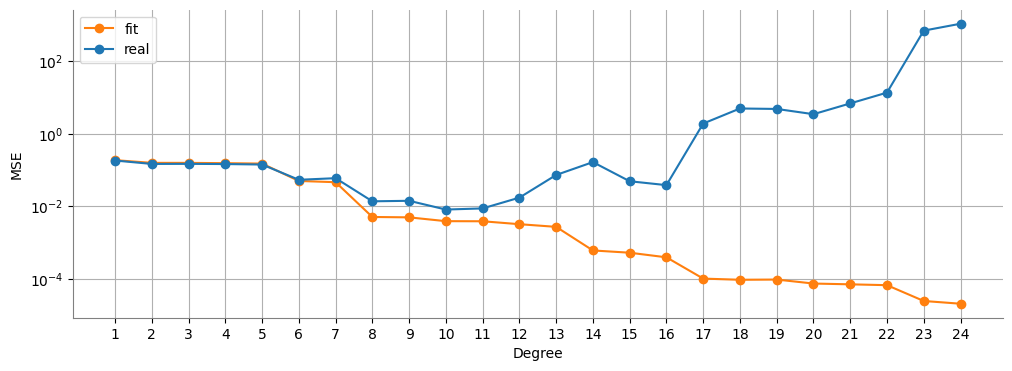

In [5]:
from sklearn.metrics import mean_squared_error

mse_fit = []
mse_real = []
degrees = list(range(1, 25))

for i_degree, degree in enumerate(degrees):

    model = make_pipeline(
        PolynomialFeatures(degree, include_bias=False),
        MinMaxScaler(),
        LinearRegression(),
    )
    model.fit(X_sample, y_sample)
    y_sample_pred = model.predict(X_sample)
    y_pred = model.predict(X_real)

    mse_fit.append(mean_squared_error(y_sample, y_sample_pred))
    mse_real.append(mean_squared_error(y_real.flatten(), y_pred))


plt.figure(figsize=(12, 4))
plt.plot(range(1, len(degrees) + 1), mse_fit, "o-", color="tab:orange", label="fit")
plt.plot(range(1, len(degrees) + 1), mse_real, "o-", color="tab:blue", label="real")

plt.yscale("log")
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(degrees)
plt.xlabel("Degree")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()